In [2]:
import time
print("Current time is:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

Current time is: 2025-09-12 22:46:31


In [12]:
# === Top level imports ===
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import functional as F
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data import DataLoader, DistributedSampler
from torch.optim.lr_scheduler import ExponentialLR

import matplotlib.pyplot as plt

import xarray as xr
import zarr
import numpy as np
from scipy.spatial import cKDTree
from scipy.interpolate import griddata
import pandas as pd
import time

import os
import wandb, argparse, sys
from tqdm import tqdm

from data_loader import nowcast_dataset, Transform
from models.Google_Unet import GoogleUNet
from models.Deep_CNN import DCNN
from models.UNet import UNet
from models.SwinT2_UNet import SwinT2UNet
from models.util import initialize_weights_xavier,initialize_weights_he
from models import predrnn_v2

from losses import MaskedErrorLoss, MaskedTVLoss, MaskedCharbonnierLoss, MaskedCombinedMAEQuantileLoss

from util import str_or_none, int_or_none, bool_from_str, EarlyStopping, save_model_checkpoint, restore_model_checkpoint, init_zarr_store
from types import SimpleNamespace

In [4]:
from matplotlib.colors import ListedColormap
turbo_colormap_data = [[0.18995,0.07176,0.23217],[0.19483,0.08339,0.26149],[0.19956,0.09498,0.29024],[0.20415,0.10652,0.31844],
                       [0.20860,0.11802,0.34607],[0.21291,0.12947,0.37314],[0.21708,0.14087,0.39964],[0.22111,0.15223,0.42558],
                       [0.22500,0.16354,0.45096],[0.22875,0.17481,0.47578],[0.23236,0.18603,0.50004],[0.23582,0.19720,0.52373],
                       [0.23915,0.20833,0.54686],[0.24234,0.21941,0.56942],[0.24539,0.23044,0.59142],[0.24830,0.24143,0.61286],
                       [0.25107,0.25237,0.63374],[0.25369,0.26327,0.65406],[0.25618,0.27412,0.67381],[0.25853,0.28492,0.69300],
                       [0.26074,0.29568,0.71162],[0.26280,0.30639,0.72968],[0.26473,0.31706,0.74718],[0.26652,0.32768,0.76412],
                       [0.26816,0.33825,0.78050],[0.26967,0.34878,0.79631],[0.27103,0.35926,0.81156],[0.27226,0.36970,0.82624],
                       [0.27334,0.38008,0.84037],[0.27429,0.39043,0.85393],[0.27509,0.40072,0.86692],[0.27576,0.41097,0.87936],
                       [0.27628,0.42118,0.89123],[0.27667,0.43134,0.90254],[0.27691,0.44145,0.91328],[0.27701,0.45152,0.92347],
                       [0.27698,0.46153,0.93309],[0.27680,0.47151,0.94214],[0.27648,0.48144,0.95064],[0.27603,0.49132,0.95857],
                       [0.27543,0.50115,0.96594],[0.27469,0.51094,0.97275],[0.27381,0.52069,0.97899],[0.27273,0.53040,0.98461],
                       [0.27106,0.54015,0.98930],[0.26878,0.54995,0.99303],[0.26592,0.55979,0.99583],[0.26252,0.56967,0.99773],
                       [0.25862,0.57958,0.99876],[0.25425,0.58950,0.99896],[0.24946,0.59943,0.99835],[0.24427,0.60937,0.99697],
                       [0.23874,0.61931,0.99485],[0.23288,0.62923,0.99202],[0.22676,0.63913,0.98851],[0.22039,0.64901,0.98436],
                       [0.21382,0.65886,0.97959],[0.20708,0.66866,0.97423],[0.20021,0.67842,0.96833],[0.19326,0.68812,0.96190],
                       [0.18625,0.69775,0.95498],[0.17923,0.70732,0.94761],[0.17223,0.71680,0.93981],[0.16529,0.72620,0.93161],
                       [0.15844,0.73551,0.92305],[0.15173,0.74472,0.91416],[0.14519,0.75381,0.90496],[0.13886,0.76279,0.89550],
                       [0.13278,0.77165,0.88580],[0.12698,0.78037,0.87590],[0.12151,0.78896,0.86581],[0.11639,0.79740,0.85559],
                       [0.11167,0.80569,0.84525],[0.10738,0.81381,0.83484],[0.10357,0.82177,0.82437],[0.10026,0.82955,0.81389],
                       [0.09750,0.83714,0.80342],[0.09532,0.84455,0.79299],[0.09377,0.85175,0.78264],[0.09287,0.85875,0.77240],
                       [0.09267,0.86554,0.76230],[0.09320,0.87211,0.75237],[0.09451,0.87844,0.74265],[0.09662,0.88454,0.73316],
                       [0.09958,0.89040,0.72393],[0.10342,0.89600,0.71500],[0.10815,0.90142,0.70599],[0.11374,0.90673,0.69651],
                       [0.12014,0.91193,0.68660],[0.12733,0.91701,0.67627],[0.13526,0.92197,0.66556],[0.14391,0.92680,0.65448],
                       [0.15323,0.93151,0.64308],[0.16319,0.93609,0.63137],[0.17377,0.94053,0.61938],[0.18491,0.94484,0.60713],
                       [0.19659,0.94901,0.59466],[0.20877,0.95304,0.58199],[0.22142,0.95692,0.56914],[0.23449,0.96065,0.55614],
                       [0.24797,0.96423,0.54303],[0.26180,0.96765,0.52981],[0.27597,0.97092,0.51653],[0.29042,0.97403,0.50321],
                       [0.30513,0.97697,0.48987],[0.32006,0.97974,0.47654],[0.33517,0.98234,0.46325],[0.35043,0.98477,0.45002],
                       [0.36581,0.98702,0.43688],[0.38127,0.98909,0.42386],[0.39678,0.99098,0.41098],[0.41229,0.99268,0.39826],
                       [0.42778,0.99419,0.38575],[0.44321,0.99551,0.37345],[0.45854,0.99663,0.36140],[0.47375,0.99755,0.34963],
                       [0.48879,0.99828,0.33816],[0.50362,0.99879,0.32701],[0.51822,0.99910,0.31622],[0.53255,0.99919,0.30581],
                       [0.54658,0.99907,0.29581],[0.56026,0.99873,0.28623],[0.57357,0.99817,0.27712],[0.58646,0.99739,0.26849],
                       [0.59891,0.99638,0.26038],[0.61088,0.99514,0.25280],[0.62233,0.99366,0.24579],[0.63323,0.99195,0.23937],
                       [0.64362,0.98999,0.23356],[0.65394,0.98775,0.22835],[0.66428,0.98524,0.22370],[0.67462,0.98246,0.21960],
                       [0.68494,0.97941,0.21602],[0.69525,0.97610,0.21294],[0.70553,0.97255,0.21032],[0.71577,0.96875,0.20815],
                       [0.72596,0.96470,0.20640],[0.73610,0.96043,0.20504],[0.74617,0.95593,0.20406],[0.75617,0.95121,0.20343],
                       [0.76608,0.94627,0.20311],[0.77591,0.94113,0.20310],[0.78563,0.93579,0.20336],[0.79524,0.93025,0.20386],
                       [0.80473,0.92452,0.20459],[0.81410,0.91861,0.20552],[0.82333,0.91253,0.20663],[0.83241,0.90627,0.20788],
                       [0.84133,0.89986,0.20926],[0.85010,0.89328,0.21074],[0.85868,0.88655,0.21230],[0.86709,0.87968,0.21391],
                       [0.87530,0.87267,0.21555],[0.88331,0.86553,0.21719],[0.89112,0.85826,0.21880],[0.89870,0.85087,0.22038],
                       [0.90605,0.84337,0.22188],[0.91317,0.83576,0.22328],[0.92004,0.82806,0.22456],[0.92666,0.82025,0.22570],
                       [0.93301,0.81236,0.22667],[0.93909,0.80439,0.22744],[0.94489,0.79634,0.22800],[0.95039,0.78823,0.22831],
                       [0.95560,0.78005,0.22836],[0.96049,0.77181,0.22811],[0.96507,0.76352,0.22754],[0.96931,0.75519,0.22663],
                       [0.97323,0.74682,0.22536],[0.97679,0.73842,0.22369],[0.98000,0.73000,0.22161],[0.98289,0.72140,0.21918],
                       [0.98549,0.71250,0.21650],[0.98781,0.70330,0.21358],[0.98986,0.69382,0.21043],[0.99163,0.68408,0.20706],
                       [0.99314,0.67408,0.20348],[0.99438,0.66386,0.19971],[0.99535,0.65341,0.19577],[0.99607,0.64277,0.19165],
                       [0.99654,0.63193,0.18738],[0.99675,0.62093,0.18297],[0.99672,0.60977,0.17842],[0.99644,0.59846,0.17376],
                       [0.99593,0.58703,0.16899],[0.99517,0.57549,0.16412],[0.99419,0.56386,0.15918],[0.99297,0.55214,0.15417],
                       [0.99153,0.54036,0.14910],[0.98987,0.52854,0.14398],[0.98799,0.51667,0.13883],[0.98590,0.50479,0.13367],
                       [0.98360,0.49291,0.12849],[0.98108,0.48104,0.12332],[0.97837,0.46920,0.11817],[0.97545,0.45740,0.11305],
                       [0.97234,0.44565,0.10797],[0.96904,0.43399,0.10294],[0.96555,0.42241,0.09798],[0.96187,0.41093,0.09310],
                       [0.95801,0.39958,0.08831],[0.95398,0.38836,0.08362],[0.94977,0.37729,0.07905],[0.94538,0.36638,0.07461],
                       [0.94084,0.35566,0.07031],[0.93612,0.34513,0.06616],[0.93125,0.33482,0.06218],[0.92623,0.32473,0.05837],
                       [0.92105,0.31489,0.05475],[0.91572,0.30530,0.05134],[0.91024,0.29599,0.04814],[0.90463,0.28696,0.04516],
                       [0.89888,0.27824,0.04243],[0.89298,0.26981,0.03993],[0.88691,0.26152,0.03753],[0.88066,0.25334,0.03521],
                       [0.87422,0.24526,0.03297],[0.86760,0.23730,0.03082],[0.86079,0.22945,0.02875],[0.85380,0.22170,0.02677],
                       [0.84662,0.21407,0.02487],[0.83926,0.20654,0.02305],[0.83172,0.19912,0.02131],[0.82399,0.19182,0.01966],
                       [0.81608,0.18462,0.01809],[0.80799,0.17753,0.01660],[0.79971,0.17055,0.01520],[0.79125,0.16368,0.01387],
                       [0.78260,0.15693,0.01264],[0.77377,0.15028,0.01148],[0.76476,0.14374,0.01041],[0.75556,0.13731,0.00942],
                       [0.74617,0.13098,0.00851],[0.73661,0.12477,0.00769],[0.72686,0.11867,0.00695],[0.71692,0.11268,0.00629],
                       [0.70680,0.10680,0.00571],[0.69650,0.10102,0.00522],[0.68602,0.09536,0.00481],[0.67535,0.08980,0.00449],
                       [0.66449,0.08436,0.00424],[0.65345,0.07902,0.00408],[0.64223,0.07380,0.00401],[0.63082,0.06868,0.00401],
                       [0.61923,0.06367,0.00410],[0.60746,0.05878,0.00427],[0.59550,0.05399,0.00453],[0.58336,0.04931,0.00486],
                       [0.57103,0.04474,0.00529],[0.55852,0.04028,0.00579],[0.54583,0.03593,0.00638],[0.53295,0.03169,0.00705],
                       [0.51989,0.02756,0.00780],[0.50664,0.02354,0.00863],[0.49321,0.01963,0.00955],[0.47960,0.01583,0.01055]]
turbo_cmap = ListedColormap(turbo_colormap_data, name="turbo")

In [5]:
# === Loading some topography and masking data ===
orography = xr.open_dataset('orography.nc')
RTMA_lat = orography.latitude.values    # Nx, Ny 2D arrays
RTMA_lon = orography.longitude.values   # Nx, Ny 2D arrays
orography = orography.set_coords(['latitude', 'longitude'])
orography = orography.orog

mask = xr.open_dataset('mask_2d.nc').mask
mask_tensor = torch.tensor(mask.values.astype(np.float32))

# Load NYSM station data
nysm = pd.read_csv('nysm.csv')
# NYSM station lat/lon
nysm_latlon = np.stack([
    nysm['lat [degrees]'].values,
    (nysm['lon [degrees]'].values + 360) % 360
], axis=-1) # shape: (N, 2)

exclude_indices = [65, 102] # Exclude these indices, since they are falling outside the NYS mask region. 

# Precompute grid KDTree
grid_points = np.stack([RTMA_lat.ravel(), RTMA_lon.ravel()], axis=-1)
tree = cKDTree(grid_points)
# Query the station locations
_, indices_flat = tree.query(nysm_latlon)
# Convert flat indices to 2D (y, x)
y_indices, x_indices = np.unravel_index(indices_flat, RTMA_lat.shape)

# PredRNN-V2 inference

In [34]:
defaults = SimpleNamespace(
    reverse_input=1,
    img_size=(256,288),
    img_channel=1,
    num_hidden="128,128,128,128",
    filter_size=5,
    stride=1,
    patch_size=(8,8),
    layer_norm=0,
    decouple_beta=0.1,
    reverse_scheduled_sampling=1,
    r_sampling_step_1=25000,
    r_sampling_step_2=50000,
    r_exp_alpha=2500,
    sampling_start_value=1,
    lr=0.0001,
    max_iterations=80000,
    display_interval=100,
    test_interval=5000,
    snapshot_interval=5000,
    pretrained_model=None,  # optional
    injection_action='concat',
    variable='i10fg',
    checkpoint_dir='checkpoints',
    model_name='predrnn_v2',
    transform='minmax',
    batch_size=32,
    loss_name='MaskedCharbonnierLoss',
    num_workers=4,
    input_window_size=36,
    output_window_size=36,
    step_size=1,
    forecast_offset=0,
)

# Back to a single name space ===
args = SimpleNamespace(**vars(defaults))

# Checkpoint dir
args.checkpoint_dir = f"{args.checkpoint_dir}/{args.model_name}"
args.checkpoint_dir = f"{args.checkpoint_dir}/{args.loss_name}"
args.checkpoint_dir = f"{args.checkpoint_dir}/{args.transform}"
args.checkpoint_dir =  f"{args.checkpoint_dir}/in_window-{args.input_window_size}_out_window-{args.output_window_size}-step-{args.step_size}_offset-{args.forecast_offset}"
os.makedirs(args.checkpoint_dir, exist_ok=True)

args.output_window_size = 72  # 6 hours
args.total_window_size = args.input_window_size + args.output_window_size

# ==================== Distributed setup ====================
if "RANK" in os.environ and "WORLD_SIZE" in os.environ:
    dist.init_process_group(backend="nccl")
    rank = dist.get_rank()
    local_rank = int(os.environ["LOCAL_RANK"])
    torch.cuda.set_device(local_rank)
    device = torch.device("cuda", local_rank)
else:
    # Fallback: single GPU (non-DDP)
    print("Running without distributed setup (no torchrun detected)")
    rank = 0
    local_rank = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

args.device = device

zarr_store = 'data/NYSM.zarr'
test_dates_range = ['2023-01-01T00:00:00','2023-12-31T23:59:59']
freq = '5min'

mask = xr.open_dataset('mask_2d.nc').mask
mask_tensor = torch.tensor(mask.values, device=args.device)  # [H, W], defnitely send it to device

NYSM_stats = xr.open_dataset('NYSM_variable_stats.nc')
input_stats = NYSM_stats.sel(variable=[args.variable])
target_stats = NYSM_stats.sel(variable=[args.variable])
# Standardization
if args.transform is not None:
    input_transform = Transform(
        mode=args.transform,  # 'standard' or 'minmax'
        stats=input_stats,
        feature_axis=-1     # Channels last
    )   
    target_transform = Transform(
        mode=args.transform,  # 'standard' or 'minmax'
        stats=target_stats,
        feature_axis=-1     # Channels last
    )
else:
    input_transform = None
    target_transform = None

test_dataset = nowcast_dataset(
zarr_store,
args.variable,
test_dates_range,
args.input_window_size,
args.output_window_size,
freq,
missing_times=None,
mode='test',
step_size=args.output_window_size,  # non-overlapping time-series in validation
forecast_offset=args.forecast_offset
)

test_sampler = None
test_dataloader = DataLoader(
    test_dataset,
    batch_size=args.batch_size,
    sampler=test_sampler,
    shuffle=(test_sampler is None), # shuffle if not using DDP
    pin_memory=True,prefetch_factor=4, persistent_workers=True,
    num_workers=args.num_workers,
    drop_last=False
)
print("Data loaded successfully.")
print(f"Test dataset size: {len(test_dataset)}")

# ============ Model setup =================
num_hidden = [int(x) for x in args.num_hidden.split(',')]
num_layers = len(num_hidden)
model = predrnn_v2.RNN(num_layers,num_hidden,args).to(args.device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = ExponentialLR(optimizer, gamma=0.9)


best_ckpt_path = os.path.join(args.checkpoint_dir, "best_model.pt")
model, _, _, _ = restore_model_checkpoint(model, optimizer, scheduler, best_ckpt_path, args.device)
metric = MaskedErrorLoss(mask_tensor).to(args.device)

# === loop over batches 
from train_PredRNN_V2 import flags_eval, forward_step
model.eval()
mask_tensor_expanded = mask_tensor[None, None, :, :, None].to(args.device)

T = args.output_window_size
sum_abs_h = np.zeros(T, dtype=np.float64)   # cumulative |err| up to horizon h
sum_sq_h  = np.zeros(T, dtype=np.float64)   # cumulative err^2 up to horizon h
cnt_h     = np.zeros(T, dtype=np.float64)   # cumulative counts up to horizon h

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="[Test]"):
        input_tensor, target_tensor, _, _ = batch
        frames_tensor = torch.cat((input_tensor, target_tensor), dim=1).unsqueeze(-1).to(args.device)
        target_tensor = target_tensor.unsqueeze(-1).to(args.device)  # [B, Tout, H, W, 1]
        masked_target_tensor = torch.where(mask_tensor_expanded, target_tensor, 0)

        Bcur = frames_tensor.size(0)
        _, real_input_flag = flags_eval(args,batch_size=Bcur)

        preds = forward_step(frames_tensor, real_input_flag,model, None, None,mask_tensor_expanded, args,input_transform, return_preds=True) # [B, Tin-1+Tout, H, W, C], already masked
        preds = preds[:, args.input_window_size-1 : ]   # [B, Tout, H, W, C]

        # ---- per-horizon accumulation (cumulative up to t) ----
        for t in range(1, T + 1):
            pred_batch   = preds[:, :t]                # [B, t, H, W,C]
            target_batch = masked_target_tensor[:, :t] # [B, t, H, W,C]

            # MAE pieces
            err_sum, counts = metric(pred_batch, target_batch, mode='mae', reduction='none')
            sum_abs_h[t-1] += err_sum.sum().item()
            cnt_h[t-1]     += counts.sum().item()

            # MSE pieces
            err_sum, counts = metric(pred_batch, target_batch, mode='mse', reduction='none')
            sum_sq_h[t-1]  += err_sum.sum().item()
            # counts are identical, so no need to add again; but harmless if you do

# Final per-horizon curves
mae_h  = sum_abs_h / cnt_h
mse_h  = sum_sq_h  / cnt_h
rmse_h = np.sqrt(mse_h)

Running without distributed setup (no torchrun detected)
Data loaded successfully.
Test dataset size: 1459
Restored checkpoint from: checkpoints/predrnn_v2/MaskedCharbonnierLoss/minmax/in_window-36_out_window-36-step-1_offset-0/best_model.pt (epoch 13)


[Test]: 100%|██████████| 46/46 [04:21<00:00,  5.69s/it]


In [61]:
# 1. Convert DL arrays into a dataframe
dl_df = pd.DataFrame({
    "MAE": mae_h,
    "MSE": mse_h,
    "RMSE": rmse_h
})
dl_df.index = range(1, len(dl_df) + 1)
dl_df

,MAE,MSE,RMSE
1,0.442694,0.387287,0.622324
2,0.468162,0.430899,0.656429
3,0.487209,0.464140,0.681278
4,0.503629,0.494409,0.703142
5,0.518142,0.522219,0.722647
...,...,...,...
68,1.140564,2.440932,1.562348
69,1.155493,2.509032,1.583992
70,1.170920,2.580740,1.606468
71,1.186893,2.656530,1.629887


In [63]:
dfs = []
for i in range(1, 73):   # 1 to 72 inclusive
    df = pd.read_csv(
        f'Predictions/Persistence/NYSM/Horizon_{i}.txt',
        header=None,
        sep=":",
    )
    df[0] = df[0].str.strip()
    df[1] = df[1].astype(float)

    # pivot to row
    df = df.set_index(0).T
    df.columns.name = None
    
    # optionally set index to i (so you know which horizon row is which)
    df.index = [i]

    dfs.append(df)

# stack all horizons together
NYSM_df = pd.concat(dfs, axis=0)

print(NYSM_df)

       MAE     MSE    RMSE
1   0.4653  0.4444  0.6667
2   0.5003  0.5056  0.7111
3   0.5262  0.5536  0.7440
4   0.5477  0.5958  0.7719
5   0.5668  0.6350  0.7968
..     ...     ...     ...
68  1.1902  2.8082  1.6758
69  1.1977  2.8438  1.6864
70  1.2052  2.8794  1.6969
71  1.2127  2.9149  1.7073
72  1.2200  2.9504  1.7177

[72 rows x 3 columns]


In [67]:
dfs = []
for i in range(1, 7):   # 1 to 6 inclusive
    df = pd.read_csv(
        f'Predictions/Persistence/RTMA/Horizon_{i}.txt',
        header=None,
        sep=":",
    )
    df[0] = df[0].str.strip()
    df[1] = df[1].astype(float)

    # pivot to row
    df = df.set_index(0).T
    df.columns.name = None
    
    # optionally set index to i (so you know which horizon row is which)
    df.index = [i]

    dfs.append(df)

# stack all horizons together
RTMA_df = pd.concat(dfs, axis=0)

print(RTMA_df)

      MAE     MSE    RMSE
1  1.0613  2.0905  1.4459
2  1.2248  2.7914  1.6707
3  1.3660  3.4907  1.8683
4  1.4978  4.2076  2.0513
5  1.6199  4.9250  2.2192
6  1.7327  5.6292  2.3726


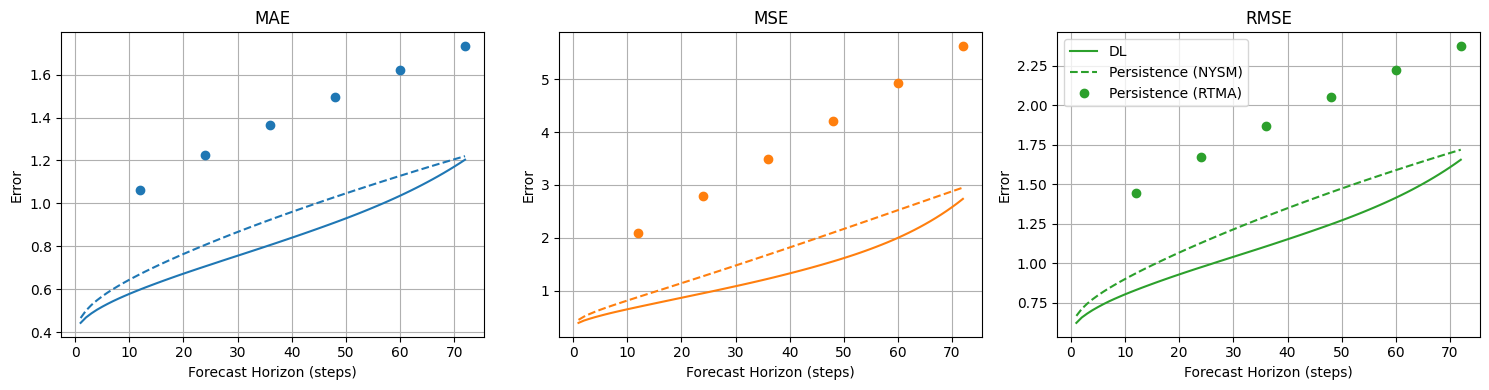

In [68]:

# --- Now plotting ---
horizons = np.arange(1, 73)   # 1 to 72

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True)

metrics = ["MAE", "MSE", "RMSE"]
colors = ["C0", "C1", "C2"]

for ax, metric, color in zip(axes, metrics, colors):
    # DL predictions (solid)
    ax.plot(horizons, dl_df[metric], label="DL", color=color, linestyle="-")

    # NYSM persistence (dashed)
    ax.plot(horizons, NYSM_df[metric], label="Persistence (NYSM)", color=color, linestyle="--")

    # RTMA persistence (markers at each hour)
    rtma_horizons = np.arange(1, len(RTMA_df) + 1) * 12  # convert 6 hours → horizon indices
    ax.plot(rtma_horizons, RTMA_df[metric], label="Persistence (RTMA)", color=color, marker="o", linestyle="None")

    ax.set_title(metric)
    ax.set_xlabel("Forecast Horizon (steps)")
    ax.set_ylabel("Error")
    ax.grid(True)

axes[2].legend(loc="best")
plt.tight_layout()
plt.show()

In [66]:
RTMA_df

,MAE,MSE,RMSE
1,1.0613,2.0905,1.4459
2,1.2248,2.7914,1.6707
3,1.3660,3.4907,1.8683
4,1.4978,4.2076,2.0513
5,1.6199,4.9250,2.2192


In [114]:
def nowcast_inference(variable,model_name,loss_name,
                      input_window_size,output_window_size,step_size,forecast_offset,
                      start_time,end_time,device_id,forecast_length,recursive=False):
    checkpoint_dir = 'checkpoints'
    activation_layer = 'gelu'
    transform = None  # 'standard' or 'minmax'
    num_workers = 16
    weights_seed = 42
    device = torch.device(f"cuda:{device_id}" if torch.cuda.is_available() else "cpu")

    checkpoint_dir = f"{checkpoint_dir}/{model_name}"
    checkpoint_dir = f"{checkpoint_dir}/{loss_name}"
    checkpoint_dir = f"{checkpoint_dir}/{transform}"
    checkpoint_dir = f"{checkpoint_dir}/{activation_layer}-{weights_seed}"
    checkpoint_dir =  f"{checkpoint_dir}/in_window-{input_window_size}_out_window-{output_window_size}-step-{step_size}_offset-{forecast_offset}"

    # === Loading some topography and masking data ===
    orography = xr.open_dataset('orography.nc')
    RTMA_lat = orography.latitude.values    # Nx, Ny 2D arrays
    RTMA_lon = orography.longitude.values   # Nx, Ny 2D arrays
    orography = orography.orog.values

    mask = xr.open_dataset('mask_2d.nc').mask
    mask_tensor = torch.tensor(mask.values, device=device)  # [H, W], defnitely send it to device

    # %%
    zarr_store = 'data/NYSM.zarr'
    test_dates_range = [start_time, end_time]
    freq = '5min'
    data_seed = 42

    NYSM_stats = xr.open_dataset('NYSM_variable_stats.nc')
    input_stats = NYSM_stats.sel(variable=[variable])
    target_stats = NYSM_stats.sel(variable=[variable])
    # Standardization
    if transform is not None:
        input_transform = Transform(
            mode=transform,  # 'standard' or 'minmax'
            stats=input_stats
        )
        target_transform = Transform(
            mode=transform,  # 'standard' or 'minmax'
            stats=target_stats
        )
    else:
        input_transform = None
        target_transform = None

    mode = 'test'
    test_dataset = nowcast_dataset(
        zarr_store,
        variable,
        test_dates_range,
        input_window_size,
        output_window_size,
        freq,
        missing_times=None,
        mode=mode,
        data_seed=data_seed,
        step_size=output_window_size,
        forecast_offset=forecast_offset,
        )
    # Set the batch size as the length of the test dataset, because we will be processing 1-3 hrs.
    batch_size = 1
    test_dataloader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        sampler=None,
        shuffle=None, # shuffle if not using DDP
        pin_memory=True,prefetch_factor=4, persistent_workers=True,
        num_workers=num_workers,
        drop_last=True
    )
    print("Data loaded successfully.")
    print(f"Test dataset size: {len(test_dataset)}")

    # === Set up device, model, loss, optimizer ===
    input_resolution = (orography.shape[0], orography.shape[1])
    in_channels = input_window_size
    out_channels = output_window_size

    if activation_layer == 'gelu':
        act_layer = nn.GELU
    elif activation_layer == 'relu':
        act_layer = nn.ReLU
    elif activation_layer == 'leakyrelu':
        act_layer = nn.LeakyReLU

    if model_name == "DCNN":
        C = 48
        kernel = (7, 7)
        final_kernel = (3, 3)
        n_layers = 7
        model = DCNN(in_channels=in_channels, 
                        out_channels=out_channels, 
                        C=C, 
                        kernel=kernel,
                        final_kernel=final_kernel, 
                        n_layers=n_layers,
                        act_layer=act_layer).to(device)
    elif model_name == "UNet":
        C = 32
        n_layers = 4
        dropout_prob=0.2
        drop_path_prob=0.2
        model = UNet(in_channels=in_channels, 
                        out_channels=out_channels,
                        C=C, 
                        dropout_prob=dropout_prob,
                        drop_path_prob=drop_path_prob,
                        act_layer=act_layer,
                        n_layers=n_layers).to(device)

    elif model_name == "SwinT2UNet":
        C = 32
        n_layers = 4
        window_sizes = [8, 8, 4, 4, 2]
        head_dim = 32
        attn_drop = 0.2
        proj_drop = 0.2
        mlp_ratio = 4.0
        model = SwinT2UNet(input_resolution=input_resolution, 
                        in_channels=in_channels, 
                        out_channels=out_channels, 
                        C=C, n_layers=n_layers, 
                        window_sizes=window_sizes,
                            head_dim=head_dim,
                            attn_drop=attn_drop,
                            proj_drop=proj_drop,
                            mlp_ratio=mlp_ratio,
                            act_layer=act_layer).to(device)

    if act_layer == nn.GELU:
            initialize_weights_xavier(model,seed = weights_seed)
    elif act_layer == nn.ReLU:
        initialize_weights_he(model,seed = weights_seed)
    elif act_layer == nn.LeakyReLU:
        initialize_weights_he(model,seed = weights_seed)

    # Define the loss criterion and metric here, based on input loss name. The functions are sent to the GPU inside
    if loss_name == "MaskedMSELoss":
        criterion = MaskedMSELoss(mask_tensor)
    elif loss_name == "MaskedRMSELoss":
        criterion = MaskedRMSELoss(mask_tensor)
    elif loss_name == "MaskedTVLoss":
        criterion = MaskedTVLoss(mask_tensor,tv_loss_weight=0.001, beta=0.5)    
    elif loss_name == "MaskedCharbonnierLoss":
        criterion = MaskedCharbonnierLoss(mask_tensor,eps=1e-3)
    metric = MaskedRMSELoss(mask_tensor)

    # === Optimizer, scheduler, and early stopping ===
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = ExponentialLR(optimizer, gamma=0.9)
    early_stopping = EarlyStopping(patience=120, min_delta=0.0)
    if not dist.is_initialized() or dist.get_rank() == 0:
        print("Model created and moved to device.")
    
    # === Restore model checkpoint if exists ===
    latest_ckpt_path = os.path.join(checkpoint_dir, "best_model.pt")
    model, _, _, _ = restore_model_checkpoint(model, optimizer, scheduler, latest_ckpt_path, device)

    iterator = iter(test_dataloader)
    all_outputs = []
    all_targets = []
    all_times = []
    with torch.no_grad():
        if recursive:
            prev_output = None
            for b in range(forecast_length):
                input_tensor, target_tensor, input_time_instance, target_time_instance = next(iterator)  
                input_tensor = input_tensor.to(device, non_blocking=True)
                target_tensor = target_tensor.to(device, non_blocking=True)

                if input_transform is not None:
                    input_tensor = input_transform(input_tensor)    # downscaled between [0,1]. 
                
                if b == 0:
                    rolling_input_tensor = input_tensor.clone()  # shape: [B, T_in, H, W]

                # === Predict output ===
                output = model(torch.where(mask_tensor, rolling_input_tensor, 0))  # shape: [B, T_out, H, W] . Output will also be in the range of [0,1].
                #output = torch.clamp(output, min=0.0)  # ensure non-negative output
                prev_output = output.clone()  # store for next round
                """
                if target_transform is not None:
                    output = target_transform.inverse(output)
                    target_tensor = target_transform.inverse(target_tensor)
                """

                all_outputs.append(prev_output.cpu())
                all_targets.append(target_tensor.cpu())
                all_times.append(pd.to_datetime(target_time_instance[0]))  # only first time of the target

                # === Replace last chunk of input with prev prediction ===
                rolling_input_tensor = torch.cat([rolling_input_tensor[:, output_window_size:], prev_output], dim=1)
                print(input_time_instance, target_time_instance)
        else:
            for b in range(forecast_length):
                input_tensor, target_tensor, input_time_instance, target_time_instance = next(iterator)  
                input_tensor = input_tensor.to(device, non_blocking=True)
                target_tensor = target_tensor.to(device, non_blocking=True)

                if input_transform is not None:
                    input_tensor = input_transform(input_tensor)
                if target_transform is not None:
                    target_tensor = target_transform(target_tensor)

                # === Predict output ===
                output = model(torch.where(mask_tensor, input_tensor, 0))
                output = model(torch.where(mask_tensor, input_tensor, 0))
                output = torch.clamp(output, min=0.0)  # ensure non-negative output
                """
                if target_transform is not None:
                    output = target_transform.inverse(output)
                    target_tensor = target_transform.inverse(target_tensor)
                """
                all_outputs.append(output.cpu())
                all_targets.append(target_tensor.cpu())
                all_times.append(pd.to_datetime(target_time_instance[0]))
                print(input_time_instance, target_time_instance)
        
    # === Construct time series ===
    forecast_times = pd.date_range(
        start=all_times[0],
        periods=forecast_length * output_window_size,
        freq=freq
    )

    # === Final output xarray objects ===
    all_outputs = torch.cat(all_outputs, dim=1)  # [B, T, H, W]
    all_targets = torch.cat(all_targets, dim=1)  # [B, T, H, W]

    if target_transform is not None:
        all_outputs = target_transform.inverse(all_outputs)

    output_ds = xr.Dataset(
        {
            variable: (['time', 'y', 'x'], all_outputs.squeeze(0).numpy())
        },
        coords={
            'time': forecast_times,
            'latitude': (('y', 'x'), RTMA_lat),
            'longitude': (('y', 'x'), RTMA_lon)
        }
    )

    target_ds = xr.Dataset(
        {
            variable: (['time', 'y', 'x'], all_targets.squeeze(0).numpy())
        },
        coords={
            'time': forecast_times,
            'latitude': (('y', 'x'), RTMA_lat),
            'longitude': (('y', 'x'), RTMA_lon)
        }
    )

    return output_ds, target_ds
    

In [115]:
output_ds_list, target_ds_list = [], []
for forecast_offset in [0]:
    output_ds, target_ds = nowcast_inference(
        variable='i10fg',
        model_name='UNet', #'SwinT2UNet', #
        loss_name='MaskedCombinedMAEQuantileLoss', #'MaskedCharbonnierLoss', #  #
        input_window_size=6,
        output_window_size=1,
        step_size=1,
        forecast_offset=forecast_offset,
        start_time='2023-03-26T02:00:00',
        end_time='2023-03-26T06:00:00',
        device_id=0,
        forecast_length=6,
        recursive=False
    )
    output_ds_list.append(output_ds)
    target_ds_list.append(target_ds)
# Combine all outputs and targets into single xarray datasets
output_ds = xr.concat(output_ds_list, dim='time')
target_ds = xr.concat(target_ds_list, dim='time')

Data loaded successfully.
Test dataset size: 43
Model created and moved to device.
Restored checkpoint from: checkpoints/UNet/MaskedCombinedMAEQuantileLoss/None/gelu-42/in_window-6_out_window-1-step-1_offset-0/best_model.pt (epoch 14)
['2023-03-26T02:00:00.000000000'] ['2023-03-26T02:30:00.000000000']
['2023-03-26T02:05:00.000000000'] ['2023-03-26T02:35:00.000000000']
['2023-03-26T02:10:00.000000000'] ['2023-03-26T02:40:00.000000000']
['2023-03-26T02:15:00.000000000'] ['2023-03-26T02:45:00.000000000']
['2023-03-26T02:20:00.000000000'] ['2023-03-26T02:50:00.000000000']
['2023-03-26T02:25:00.000000000'] ['2023-03-26T02:55:00.000000000']


Text(0, 0.5, 'Wind gust (m/s)')

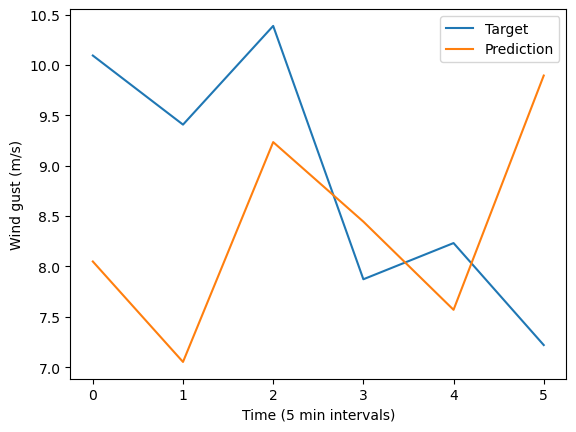

In [116]:
indice = 51
plt.plot(target_ds.i10fg.values[:,y_indices[indice],x_indices[indice]],label='Target')
plt.plot(output_ds.i10fg.values[:,y_indices[indice],x_indices[indice]], label='Prediction')
plt.legend()
plt.xlabel('Time (5 min intervals)')
plt.ylabel('Wind gust (m/s)')

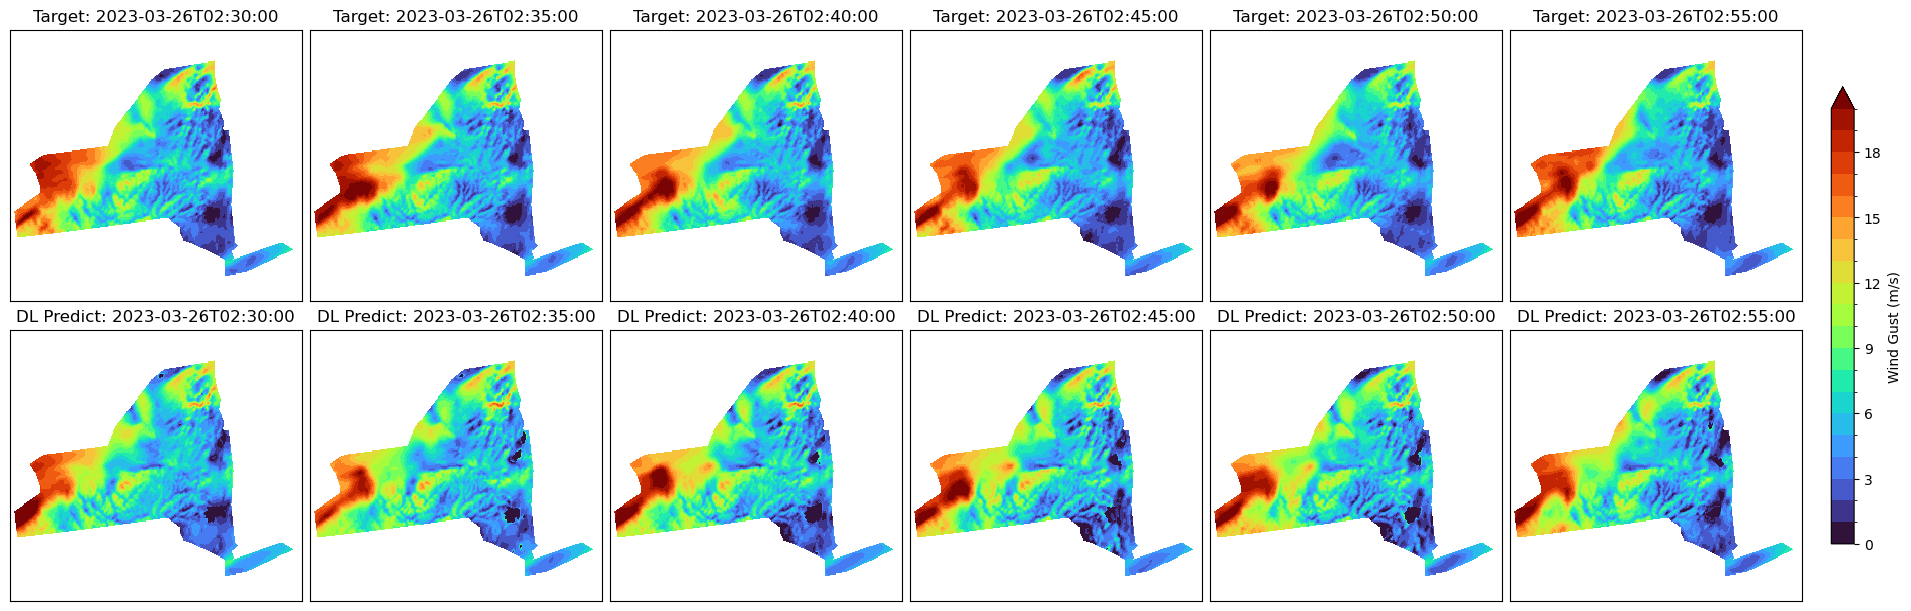

In [119]:
fig, axes = plt.subplots(2,output_ds.sizes['time'], figsize=(19, 6), constrained_layout=True)

levels = np.arange(0,20.1,1)  # Adjust levels as needed
for i in range(output_ds.sizes['time']):
    # Plot output
    ax = axes[0,i]
    im0 = target_ds.i10fg.isel(time=i).where(mask).plot(ax=ax,cmap=turbo_cmap, levels=levels, vmin=levels[0], vmax=levels[-1], add_colorbar=False)
    ax.set_title(f"Target: {target_ds.time.values[i].astype('datetime64[s]')}")
    ax.set_xticks([]), ax.set_yticks([])
    ax.set_xlabel(''), ax.set_ylabel('')

    # Plot target
    ax = axes[1,i]
    im1 = output_ds.i10fg.isel(time=i).where(mask).plot(ax=ax, cmap=turbo_cmap, levels=levels, vmin=levels[0], vmax=levels[-1], add_colorbar=False)
    ax.set_title(f"DL Predict: {output_ds.time.values[i].astype('datetime64[s]')}")

    ax.set_xticks([]), ax.set_yticks([])
    ax.set_xlabel(''), ax.set_ylabel('')

# Add common colorbar
cbar = fig.colorbar(im1, ax=axes[:,5], orientation='vertical', shrink=0.8, pad=0.1)
cbar.set_label("Wind Gust (m/s)")

plt.savefig('Sample_forecast.png', dpi=300, bbox_inches='tight')

In [ ]:
output_ds.i10fg

<xarray.Dataset>
Dimensions:    (time: 6, y: 256, x: 288)
Coordinates:
  * time       (time) datetime64[ns] 2023-03-26T02:30:00 ... 2023-03-26T02:55:00
    latitude   (y, x) float64 40.73 40.73 40.73 40.73 ... 45.32 45.31 45.31 45.3
    longitude  (y, x) float64 279.9 279.9 279.9 279.9 ... 289.3 289.3 289.4
Dimensions without coordinates: y, x
Data variables:
    i10fg      (time, y, x) float32 3.979 3.874 3.892 ... 4.163 4.141 4.101

In [8]:
iterator = iter(test_dataloader)
with torch.no_grad():
    # Example usage
    for b in range(1):
        start_time = time.time()
        batch = next(iterator, None)

        if batch is not None:
            input_tensor, target_tensor, input_time_instances, target_time_instances = batch
            input_tensor = input_tensor.to(device, non_blocking=True)
            target_tensor = target_tensor.to(device, non_blocking=True)

            # Transform input and target
            if input_transform is not None:
                input_tensor = input_transform(input_tensor)
                target_tensor = target_transform(target_tensor)
                
            output = model(torch.where(mask_tensor, input_tensor, 0))  # shape: [13, 1, H, W] if batch size = 13
            print(criterion(torch.where(mask_tensor, output, 0), torch.where(mask_tensor, target_tensor, 0)))   # Not transformed
            print(metric(torch.where(mask_tensor, output, 0), torch.where(mask_tensor, target_tensor, 0)))  # Not transformed
            print(metric_2(torch.where(mask_tensor, output, 0), torch.where(mask_tensor, target_tensor, 0)))  # Not transformed
            
            if target_transform is not None:
                output = target_transform.inverse(output)
                target_tensor = target_transform.inverse(target_tensor)
            print(criterion(torch.where(mask_tensor, output, 0), torch.where(mask_tensor, target_tensor, 0)))   # transformed, so m/s
            print(metric(torch.where(mask_tensor, output, 0), torch.where(mask_tensor, target_tensor, 0)))  # Trnasformed, so m/s
            print(metric_2(torch.where(mask_tensor, output, 0), torch.where(mask_tensor, target_tensor, 0)))  # Trnasformed, so m/s

tensor(0.1554, device='cuda:0')
tensor(0.2183, device='cuda:0')
tensor(0.1206, device='cuda:0')
tensor(0.4003, device='cuda:0')
tensor(0.5623, device='cuda:0')
tensor(0.3105, device='cuda:0')


In [64]:
output_ds = xr.Dataset(
        {
            variable: (['time', 'y', 'x'], output.squeeze(1).cpu().numpy())
        },
        coords={
        'time': np.array(target_time_instances, dtype='datetime64[ns]'),
        'latitude': (('y', 'x'), RTMA_lat),
        'longitude': (('y', 'x'), RTMA_lon)
        }
    )
target_ds = xr.Dataset(
        {
            variable: (['time', 'y', 'x'], target_tensor.squeeze(1).cpu().numpy())
        },
        coords={
        'time': np.array(target_time_instances, dtype='datetime64[ns]'),
        'latitude': (('y', 'x'), RTMA_lat),
        'longitude': (('y', 'x'), RTMA_lon)
        }
    )

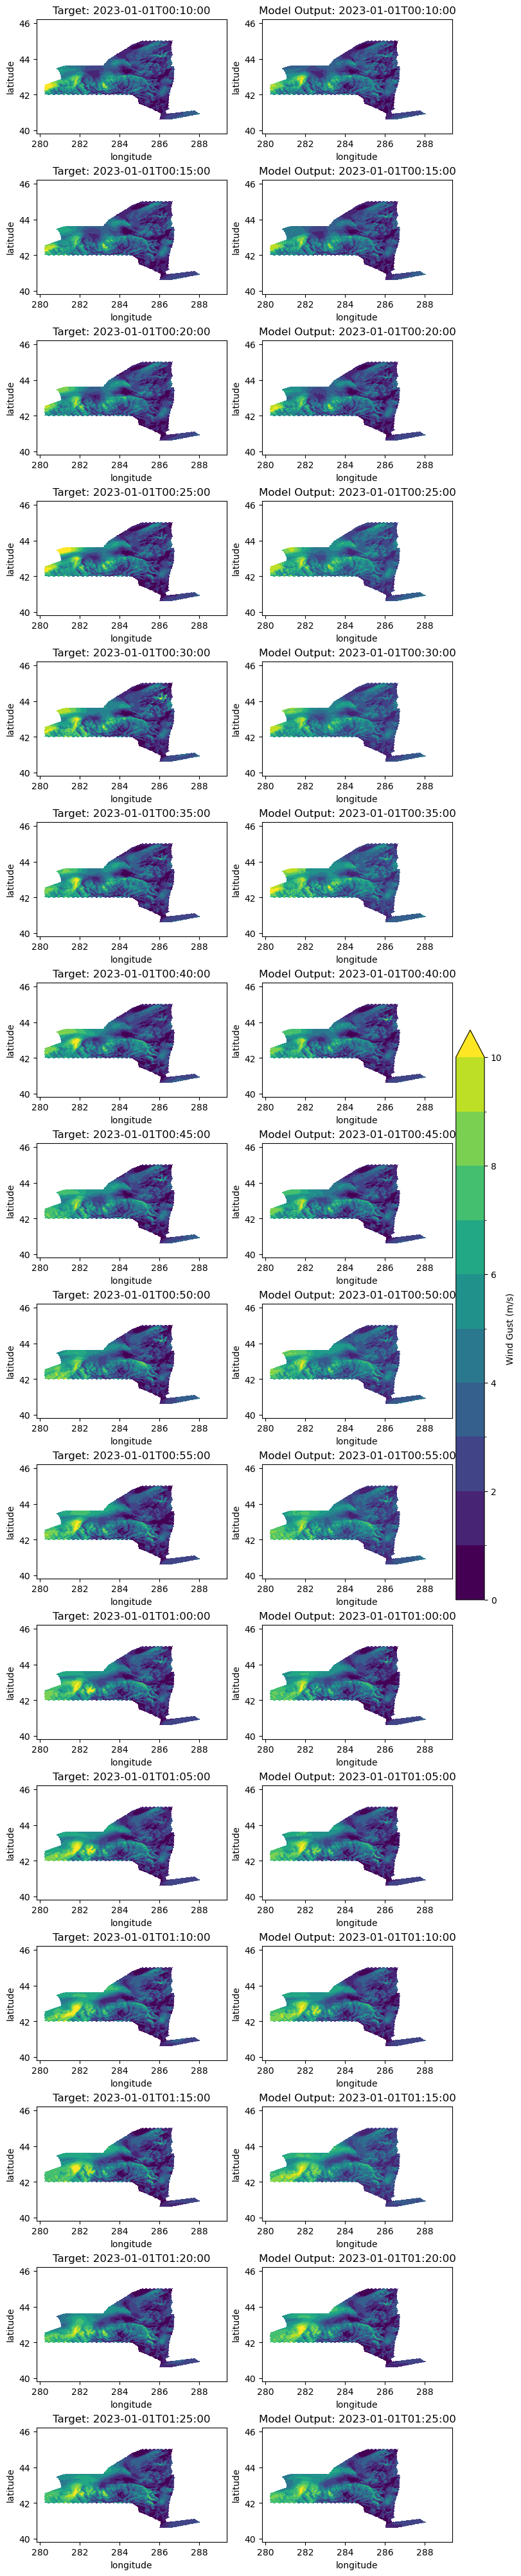

In [65]:
fig, axes = plt.subplots(output_ds.sizes['time'], 2, figsize=(8, 40), constrained_layout=True)

levels = np.arange(0,10.1,1)  # Adjust levels as needed
for i in range(output_ds.sizes['time']):
    # Plot output
    ax = axes[i,0]
    im0 = target_ds.i10fg.isel(time=i).where(mask).plot(ax=ax, x='longitude', y='latitude', cmap='viridis', levels=levels, vmin=levels[0], vmax=levels[-1], add_colorbar=False)
    ax.set_title(f"Target: {target_ds.time.values[i].astype('datetime64[s]')}")

    # Plot target
    ax = axes[i,1]
    im1 = output_ds.i10fg.isel(time=i).where(mask).plot(ax=ax, x='longitude', y='latitude', cmap='viridis', levels=levels, vmin=levels[0], vmax=levels[-1], add_colorbar=False)
    ax.set_title(f"Model Output: {output_ds.time.values[i].astype('datetime64[s]')}")

# Add common colorbar
cbar = fig.colorbar(im1, ax=axes[:,1], orientation='vertical', shrink=0.8, pad=0.02)
cbar.set_label("Wind Gust (m/s)")